# HW 11

<b>9923081 _ 992393 _ 40023024</b><br>

#### RL for Card-Pole

In this section کتابخانه های مورد نیاز را فراخوانی می کنیم

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F



در اینجا مدل 

DQN

we define.The inputs of this class حالات پردازش the number of neurons in the first layer و the number of actions in the model می باشد

سپس در تابع 

forward

The first layer ورودی هارا transfers to the hidden layer and then the output layer generates the outputs.

In [4]:
# Define model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()
        self.fc1 = nn.Linear(in_states, h1_nodes)   # First fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # Output layer
    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply ReLU activation
        x = self.out(x)         # Calculate output
        return x



In this section memory buffer class we define
First در بخش تعریف با استفاده از 

deque

مانع از پر شدن بیش از حد خافظه میشود

در تابع بعدی new experiences are added

سپس یکسری از experiences را به صورت تصادفی returned from the memory

تابع اخر هم the current size of the memory را برمیگرداند


In [6]:
# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)



In this section کلاس مربوط به آونگ معکوس را تعریف میکنیم

First هایپرپارامتر های آن تنظیم می شوند که در کامنت های کناری توضیح اده شده است

سپس تابع آموزش فعالیت یادگیری را انجام می دهد

سپس بهینه سازی انجام می شود

و در اخر شبکه هدف همگام می شود و نتیجه رسم می شود


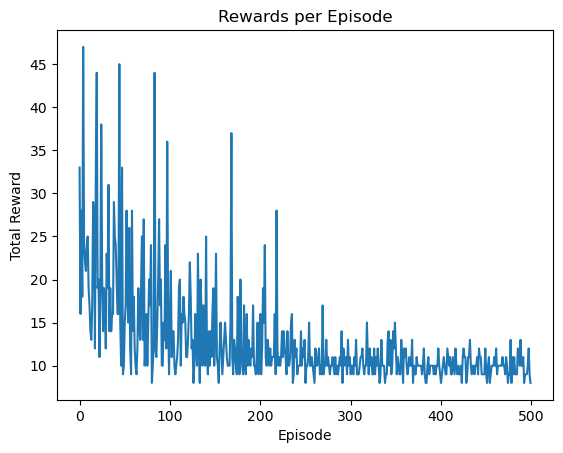

In [7]:
# CartPole Deep Q-Learning
class CartPoleDQL():
    # Hyperparameters
    learning_rate_a = 0.001         # Learning rate (alpha)
    discount_factor_g = 0.99        # Discount rate (gamma)    
    network_sync_rate = 10          # Steps before syncing policy and target network
    replay_memory_size = 1000       # Size of replay memory
    mini_batch_size = 32            # Size of training data set sampled from replay memory

    loss_fn = nn.MSELoss()          # Loss function
    optimizer = None                 # Optimizer

    ACTIONS = [0, 1]                # Actions: 0 = left, 1 = right

    # Train the CartPole environment
    def train(self, episodes, render=False):
        # Create CartPole instance
        env = gym.make('CartPole-v1', render_mode='human' if render else None)
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n
        
        epsilon = 1.0  # Start with full exploration
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network
        policy_dqn = DQN(in_states=num_states, h1_nodes=64, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=64, out_actions=num_actions)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        # Optimizer
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode
        rewards_per_episode = np.zeros(episodes)
        step_count = 0
            
        for i in range(episodes):
            state, _ = env.reset()  # Initialize to state
            terminated = False
            truncated = False
            total_reward = 0

            while not terminated and not truncated:
                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    action = env.action_space.sample()  # Random action
                else:
                    with torch.no_grad():
                        # Ensure the state is a torch tensor of the correct shape
                        state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Shape (1, num_states)
                        action = policy_dqn(state_tensor).argmax().item()

                # Execute action
                new_state, reward, terminated, truncated, _ = env.step(action)

                # Accumulate reward
                total_reward += reward
                # Save experience into memory
                memory.append((state, action, new_state, reward, terminated))

                # Move to the next state
                state = new_state
                step_count += 1

            rewards_per_episode[i] = total_reward

            # Check if enough experience has been collected
            if len(memory) > self.mini_batch_size:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Epsilon decay
                epsilon = max(epsilon * 0.995, 0.01)  # Gradual decay

                # Sync target network
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0

        env.close()

        # Plot average rewards
        plt.figure()
        plt.plot(rewards_per_episode)
        plt.title('Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):
        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated: 
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(reward + self.discount_factor_g * target_dqn(torch.FloatTensor(new_state)).max())

            current_q = policy_dqn(torch.FloatTensor(state))
            current_q_list.append(current_q)

            target_q = target_dqn(torch.FloatTensor(state)) 
            target_q[action] = target
            target_q_list.append(target_q)
                
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    # Print DQN: state, best action, q values
    def print_dqn(self, dqn):
        num_states = dqn.fc1.in_features
        for s in range(num_states):
            q_values = dqn(torch.FloatTensor([s])).tolist()
            best_action = self.ACTIONS[q_values.index(max(q_values))]
            print(f'State: {s}, Best Action: {best_action}, Q Values: {q_values}')

# Usage example
if __name__ == "__main__":
    agent = CartPoleDQL()
    agent.train(episodes=500, render=True)


C:\Users\setak\AppData\Local\Temp\ipykernel_25400\3539085657.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\b\abs_f0dma8qm3d\croot\pytorch_1669187301762\work\torch\csrc\utils\tensor_new.cpp:204.)
  states = torch.FloatTensor(states)


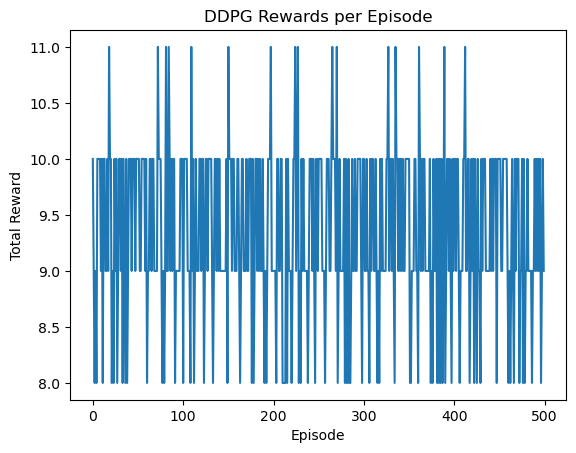

In [8]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
import torch.optim as optim
from collections import deque

# Hyperparameters
GAMMA = 0.99
TAU = 0.005
LR_ACTOR = 0.001
LR_CRITIC = 0.002
MEMORY_SIZE = 100000
BATCH_SIZE = 64

# Define the Actor network
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))  # Action space normalization

# Define the Critic network
class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128 + action_size, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(torch.cat((x, action), dim=1)))
        return self.fc3(x)

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_size, action_size):
        self.actor = Actor(state_size, action_size)
        self.critic = Critic(state_size, action_size)
        self.target_actor = Actor(state_size, action_size)
        self.target_critic = Critic(state_size, action_size)
        
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)

        # Initialize target networks
        self.update_target_networks(tau=1.0)

    def update_target_networks(self, tau=TAU):
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        return self.actor(state).detach().numpy()[0]

    def train(self):
        if len(self.memory) < BATCH_SIZE:
            return

        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Train Critic
        next_actions = self.target_actor(next_states)
        target_q = self.target_critic(next_states, next_actions)
        expected_q = rewards + GAMMA * target_q * (1 - dones)

        self.critic_optimizer.zero_grad()
        current_q = self.critic(states, actions)
        critic_loss = F.mse_loss(current_q, expected_q.detach())
        critic_loss.backward()
        self.critic_optimizer.step()

        # Train Actor
        self.actor_optimizer.zero_grad()
        policy_loss = -self.critic(states, self.actor(states)).mean()
        policy_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        self.update_target_networks()

# Train the DDPG agent
def train_ddpg(episodes):
    env = gym.make('CartPole-v1')
    agent = DDPGAgent(state_size=env.observation_space.shape[0], action_size=1)  # Continuous action space
    rewards_per_episode = []

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(int(action > 0))  # Discretize action
            agent.remember(state, action, reward, next_state, terminated)
            agent.train()

            state = next_state
            total_reward += reward
            done = terminated or truncated

        rewards_per_episode.append(total_reward)

    env.close()

    # Plot results
    plt.plot(rewards_per_episode)
    plt.title('DDPG Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

# Run the training
if __name__ == "__main__":
    train_ddpg(episodes=500)
